###                                         Code Review Metrics Analytics Project

* Primary Goal: To analyze code review patterns, reviewer engagement, file stability, and overall efficiency in the code review process, identifying areas for potential improvement.
* Specific Objectives:
    * Understand code change dynamics (revisions, review cycles, and churn).
    * Identify top contributors, active reviewers, and areas of high/low engagement.
    * Analyze feedback timing and response times for process optimization.
    * Gauge code stability by examining frequent revisions and file churn.

In [1]:
# Give the necessary input variables such as database credentials and .txt file in the environment.ini file
# Few functions are written and stored in the utils folder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from environment import *
from logs import create_logger
from utils import *
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


In [2]:
# Data Retrieval: Fetch all five data tables from the MySQL database.
empty_value_counts = {}
logger  = create_logger()
# get_data_from_database : Refer the function Written in utils
table_dataframes = get_data_from_database(DataBase_SchemaQuery, Host, User, PassWord, DataBase)
for table_name in list(table_dataframes.keys()):
    df = table_dataframes[table_name]
    logger.info(f"Check null or empty values in each column of the table : {table_name}")
    # Get all the table data, table_data_info : : Refer the function Written in utils
    # Data Quality Assessment: Check data types and identify null or empty values in each table.
    empty_value_counts[table_name] = table_data_info(df, table_name)

In [3]:
# Define the Data Tables
t_change = table_dataframes['t_change']
t_file = table_dataframes['t_file']
t_history = table_dataframes['t_history']
t_people = table_dataframes['t_people']
t_revision = table_dataframes['t_revision']

#### Handling Missing Values and Data Types

In [4]:
# Fill missing values : Data Imputation: Fill null or empty values
t_change['ch_topic'] = t_change['ch_topic'].replace('', pd.NA).fillna('No topic')
t_change['ch_mergeable'] = t_change['ch_mergeable'].replace('', pd.NA).fillna('1')

t_history['hist_message'] = t_history['hist_message'].replace('', pd.NA).fillna('No message')
t_history['hist_authorAccountId'] = t_history['hist_authorAccountId'].replace('', pd.NA).fillna('Unknown')

t_people['p_name'] = t_people['p_name'].replace('', pd.NA).fillna('Unknown_name')
t_people['p_email'] = t_people['p_email'].replace('', pd.NA).fillna('No_email_found')
t_people['p_userName'] = t_people['p_userName'].replace('', pd.NA).fillna('Unknown_username')

t_revision['rev_subject'] = t_revision['rev_subject'].replace('', pd.NA).fillna('No_subject_info')

In [5]:
# COnverting datatypes of Few columns, covert_data_types : : Refer the function Written in utils
# Data Type Conversion: Convert data types for necessary columns.
convert_data_types(t_change, t_file, t_history, t_revision)

#### Data Exploration, Outliers and Statistics
Data Exploration and Transformation

In [6]:
print(t_change.describe())
print(t_people.describe())
print(t_revision.describe())

                      ch_createdTime                 ch_updatedTime
count                          57376                          57376
mean   2015-09-12 22:10:47.822504192  2015-09-18 16:37:07.562726656
min              2013-10-03 18:32:26            2013-10-03 18:45:12
25%    2015-03-02 21:48:57.750000128  2015-03-06 18:11:25.249999872
50%       2015-09-29 01:15:47.500000            2015-10-09 19:23:22
75%    2016-04-19 20:34:21.750000128  2016-04-26 14:02:38.750000128
max              2016-11-19 01:25:19            2016-11-19 01:30:57
                id
count  2534.000000
mean   1267.500000
std     731.647114
min       1.000000
25%     634.250000
50%    1267.500000
75%    1900.750000
max    2534.000000
                     rev_createdTime              rev_committedTime
count                         106957                         106957
mean   2015-09-25 01:07:22.174303744  2015-10-05 01:06:28.518226944
min              2011-10-05 13:00:05            2011-10-05 13:00:05
25%          

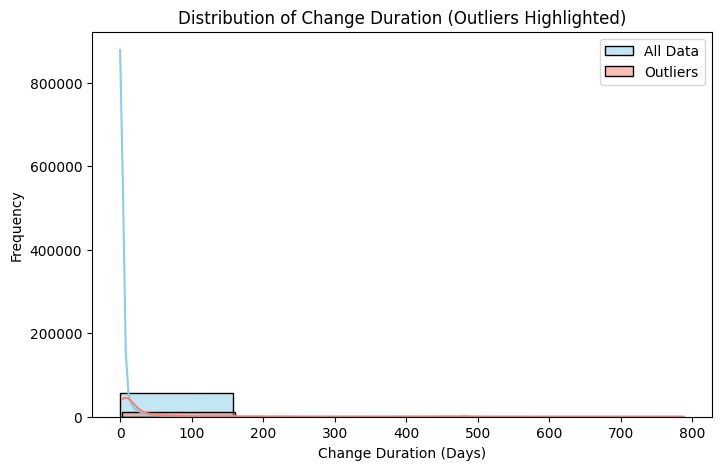

In [7]:
# t_change Data and Its Outliers
t_change['change_duration'] = (t_change['ch_updatedTime'] - t_change['ch_createdTime']).dt.days

# Detecting outliers using the IQR method for change duration
Q1 = t_change['change_duration'].quantile(0.25)
Q3 = t_change['change_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside 1.5 * IQR
outliers = t_change[(t_change['change_duration'] < (Q1 - 1.5 * IQR)) | 
                    (t_change['change_duration'] > (Q3 + 1.5 * IQR))]

# Plot histogram with KDE for non-outliers and overlay outliers
plt.figure(figsize=(8, 5))
sns.histplot(t_change['change_duration'], bins=5, kde=True, color='skyblue', label='All Data')
sns.histplot(outliers['change_duration'], bins=5, kde=True, color='salmon', label='Outliers')
plt.title("Distribution of Change Duration (Outliers Highlighted)")
plt.xlabel("Change Duration (Days)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Exclude outliers in t_change dataset
# t_change = t_change[~t_change.index.isin(outliers.index)]

In [8]:
# Change Duration: Most code changes are completed quickly, but some outliers indicate significantly prolonged cycles, suggesting potential blockers or complex reviews.
print("Prolonged Change Durations:")
print(outliers[['id', 'change_duration']])

Prolonged Change Durations:
          id  change_duration
11        12               15
13        14                4
17        18                6
28        29               71
30        31                7
...      ...              ...
57348  57349               17
57349  57350               18
57350  57351               18
57351  57352               20
57352  57353               20

[10865 rows x 2 columns]


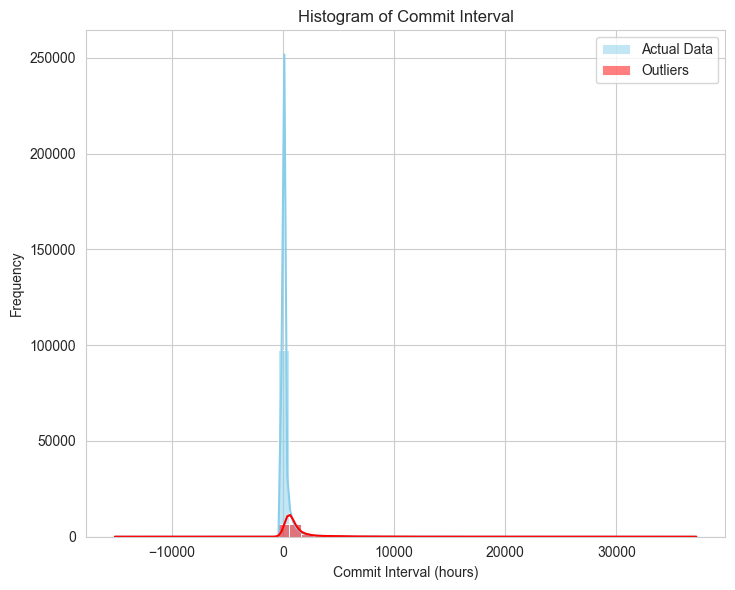

In [9]:
# t_revision Data and Its Outliers
t_revision['commit_interval'] = (t_revision['rev_committedTime'] - t_revision['rev_createdTime']).dt.total_seconds() / 3600 #(hr)

# Detect outliers for commit interval
Q1_commit = t_revision['commit_interval'].quantile(0.25)
Q3_commit = t_revision['commit_interval'].quantile(0.75)
IQR_commit = Q3_commit - Q1_commit

outliers_commit_interval = t_revision[(t_revision['commit_interval'] < (Q1_commit - 1.5 * IQR_commit)) | 
                                      (t_revision['commit_interval'] > (Q3_commit + 1.5 * IQR_commit))]

# Set plot size and style
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
# 2. Histogram showing distribution of commit_interval and overlay of outliers
plt.subplot(1, 2, 2)
sns.histplot(t_revision['commit_interval'], bins=50, color="skyblue", label="Actual Data", kde=True)
sns.histplot(outliers_commit_interval['commit_interval'], bins=50, color="red", label="Outliers", kde=True)
plt.title('Histogram of Commit Interval')
plt.xlabel('Commit Interval (hours)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Commit Interval: A high variance in commit intervals, where longer intervals may indicate challenges in the review process, while shorter intervals suggest quicker processing.
high_interval = t_revision[t_revision['commit_interval'] > t_revision['commit_interval'].mean() + t_revision['commit_interval'].std()]
print("High Commit Intervals:")
print(high_interval[['id', 'commit_interval']])

High Commit Intervals:
            id  commit_interval
64          65      1727.141667
66          67      1673.325833
67          68      1673.421389
68          69      1673.431111
69          70      1343.213889
...        ...              ...
106523  106524      1319.847778
106524  106525      1319.842500
106537  106538      1319.660000
106554  106555      1319.671389
106658  106659      6702.880556

[4030 rows x 2 columns]


In [11]:
# t_history Data (hist_message length: unusually long comments might indicate complex discussions or detailed explanations)
# Calculate the length of each comment message
t_history['message_length'] = t_history['hist_message'].str.len()
t_history.describe()

,hist_createdTime,message_length
count,435814,435814.000000
mean,2015-10-17 00:04:27.592467712,141.632644
min,2013-10-03 18:33:09,8.000000
25%,2015-05-01 03:52:52,26.000000
50%,2015-10-23 10:05:00,60.000000
75%,2016-04-22 17:05:22.500000,111.000000
max,2016-11-19 01:30:57,166835.000000
std,NaN,1884.482844


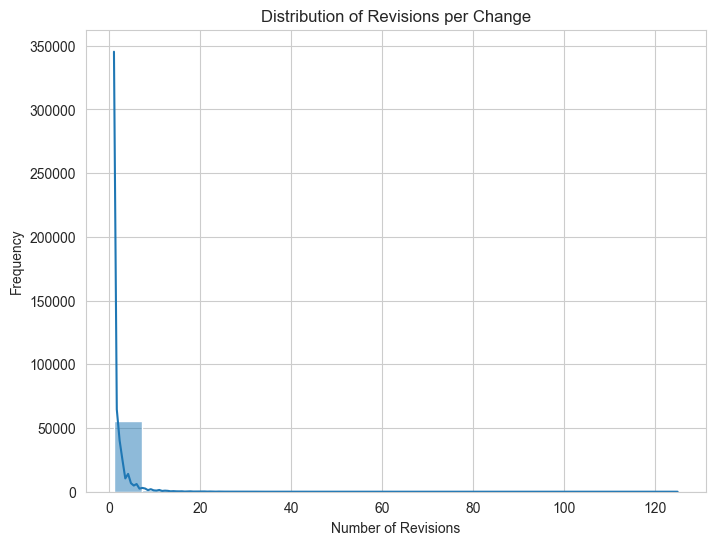

In [12]:
# Count revisions per change
revisions_per_change = t_revision['rev_changeId'].value_counts()
# Revisions per Change distribution
plt.figure(figsize=(8, 6))
sns.histplot(revisions_per_change, bins=20, kde=True)
plt.title("Distribution of Revisions per Change")
plt.xlabel("Number of Revisions")
plt.ylabel("Frequency")
plt.show()

Insights from Each Decision:
1.	Total Changes: Helps understand the overall volume of code changes.
2.	Changes Per Project: Reveals project activity levels for Top 10.
3.	Changes by Status: Indicates code lifecycl and approval rates.
4.	Distribution of Changes Across Branches: Shows which branches see the most development.
5.	Average Revisions per Change: Measures the tendency to rework or modify code.
6.	Top 5 Most Revised Changes: Identifies specific cases of extensive modification.
7.	Total Comments per Change: Helps assess the level of feedback per code change.
8.	Average Comments per Revision: Suggests revision depth based on feedback.
9.	Average Lines Inserted per Revision: Shows the extent of code additions.
10.	Average Lines Deleted per Revision: Reveals the extent of code removals.
11.	Top 10 Contributors by Change Count: Shows the most active contributors.
12.	Top 10 Contributors by Revision Count: Highlights developers with significant involvement.
13.	Contributors with the Most Comments: Identifies frequent reviewers or commenters.
14.	Average Time between Revisions: Provides insight into workflow pace.
15.	Peak Hours for Commenting: Suggests optimal engagement times.
16.	Days with Highest Change Activity: Determines high-development days.
17.	Comment Count Trends over Time: Assesses feedback evolution over time.
18.	Average Files Changed per Revision: Indicates the typical scope of changes.
19.	Projects with Highest Code Churn: Identifies projects with intensive code modification.
20.	Revisions with Most Comments: Points to heavily scrutinized or debated revisions.

In [13]:
# 1. Total Changes
total_changes = t_change['ch_changeId'].nunique()
logger.info(f"Total number of unique changes: {total_changes}")
print(f"Total number of unique changes: {total_changes}")

Total number of unique changes: 55560


In [14]:
# 2. Changes Per Project
changes_per_project = t_change['ch_project'].value_counts().head(10)
logger.info(f"Top 10 Projects by Change Count:\n{changes_per_project}")
print((f"Top 10 Projects by Change Count:\n{changes_per_project}"))

Top 10 Projects by Change Count:
ch_project
midonet/midonet              4340
redhat-openstack/khaleesi    2915
Distrotech/linux             1758
riscv/riscv-go               1405
redhat-openstack/tempest     1367
serup/CloudChat              1290
ffilz/nfs-ganesha            1122
redhat-openstack/rally        821
Distrotech/buildscripts       687
midonet/midonet-docs          663
Name: count, dtype: int64


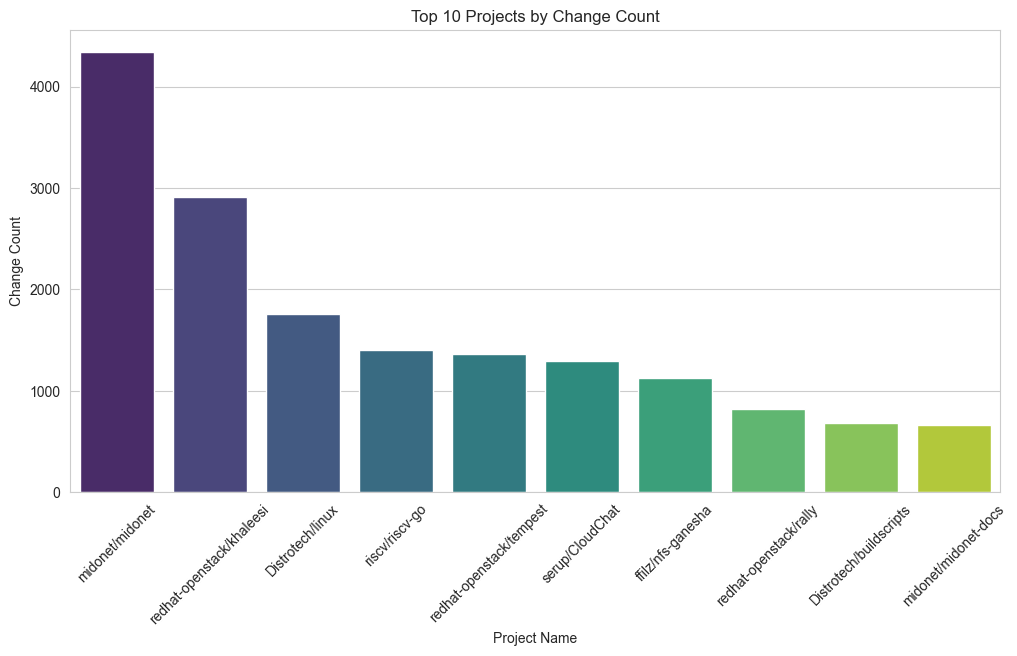

In [15]:
# Plot changes per project
plt.figure(figsize=(12, 6))
sns.barplot(x=changes_per_project.index, y=changes_per_project.values, palette='viridis')
plt.title("Top 10 Projects by Change Count")
plt.xticks(rotation=45)
plt.xlabel("Project Name")
plt.ylabel("Change Count")
plt.show()

ch_status
MERGED       38595
ABANDONED    10592
NEW           8189
Name: count, dtype: int64


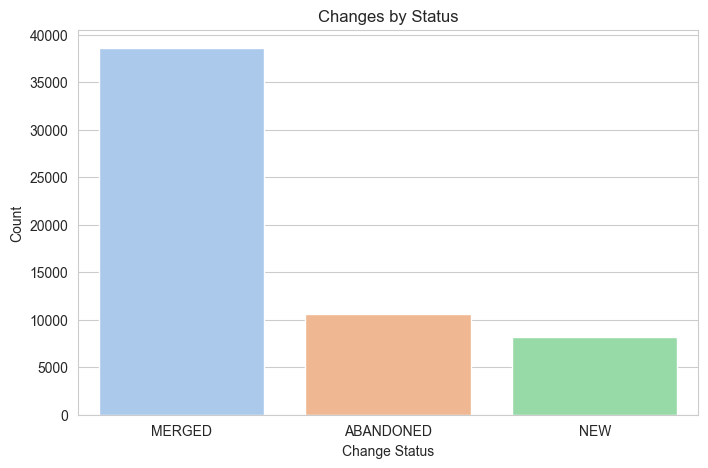

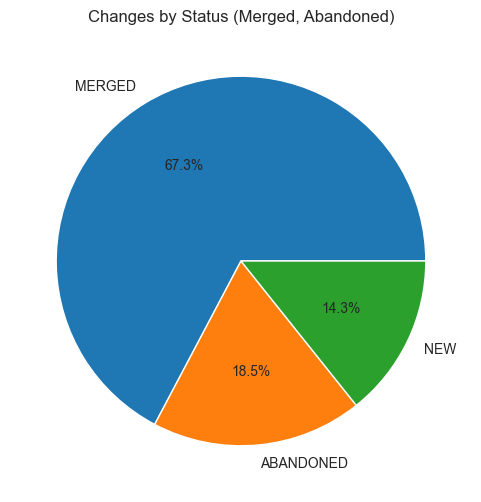

In [16]:
# 3. Changes by Status
change_status_counts = t_change['ch_status'].value_counts()
print(change_status_counts)
logger.info(change_status_counts)
plt.figure(figsize=(8, 5))
sns.barplot(x=change_status_counts.index, y=change_status_counts.values, palette='pastel')
plt.title("Changes by Status")
plt.xlabel("Change Status")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(change_status_counts, labels=change_status_counts.index, autopct="%1.1f%%")
plt.title("Changes by Status (Merged, Abandoned)")
plt.show()

Changes per Branch:
 ch_branch
master                   36270
distrotech-linux-3.14     1740
next                      1421
riscvdev                  1403
serup                     1316
develop                    598
rpm-master                 540
staging/v5.0               534
mm                         502
devel                      498
Name: count, dtype: int64


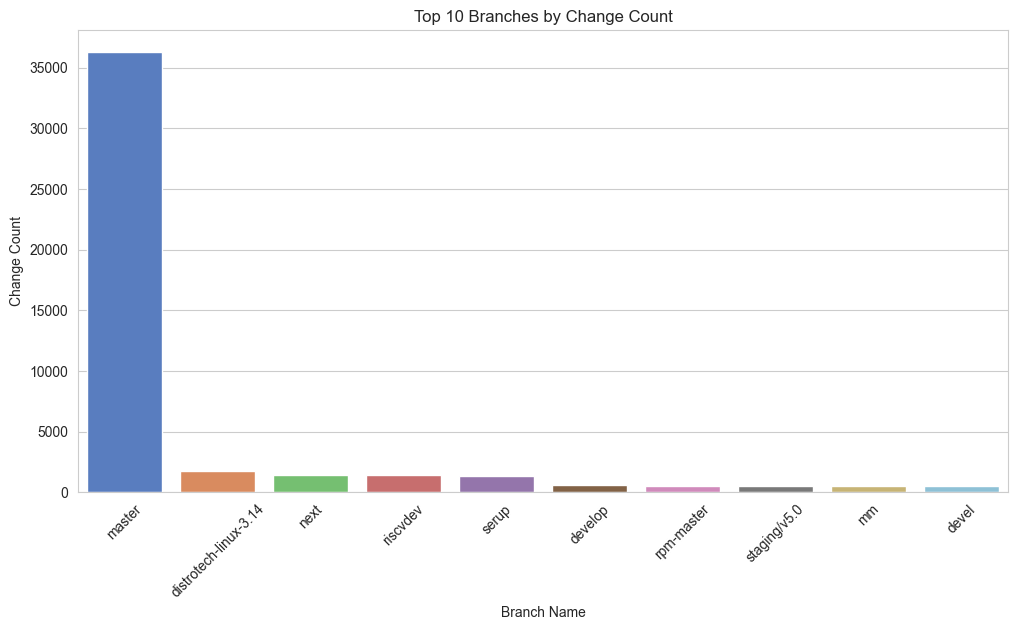

In [17]:
# 4. Distribution of Changes Across Branches
branch_changes = t_change['ch_branch'].value_counts().head(10)
print("Changes per Branch:\n", branch_changes)
logger.info(f"Changes per Branch:\n, {branch_changes}")
plt.figure(figsize=(12, 6))
sns.barplot(x=branch_changes.index, y=branch_changes.values, palette='muted')
plt.title("Top 10 Branches by Change Count")
plt.xticks(rotation=45)
plt.xlabel("Branch Name")
plt.ylabel("Change Count")
plt.show()

In [18]:
# Changes by Project and Branch
project_branch_counts = t_change.groupby(['ch_project', 'ch_branch']).size().reset_index(name='change_count')
print("Changes by Project and Branch:\n", project_branch_counts)

Changes by Project and Branch:
                                       ch_project ch_branch  change_count
0     007-surajit/Directory-List-PhoneGap-Plugin    master             1
1                   091387-ea975-lab3/ea975-lab3    master             1
2                                   184389/ZPI_2    master             4
3                                   184389/ZPI_3    master             1
4                              184389/ZPI_Gerrit    master             5
...                                          ...       ...           ...
5029                    zolwojtek/ProjektGrupowy    master            16
5030                          zork2020/tanks2016    master             3
5031        zzaponka/zzaponka_repo_for_gerrithub    master             2
5032                           zzez12/ZFramework    master             1
5033                           zzzeek/sqlalchemy    master             4

[5034 rows x 3 columns]


In [19]:
# 5. Average Revisions per Change
average_revisions = t_revision['rev_changeId'].value_counts().mean()
logger.info(f"Average revisions per change: {round(average_revisions)}")
print(f"Average revisions per change: {round(average_revisions)}")

Average revisions per change: 2


In [20]:
#6. Top 5 Most Revised Changes
most_revised_changes = t_revision['rev_changeId'].value_counts().head(5)
logger.info(f"Top 5 Most Revised Changes:\n{most_revised_changes}")
print(f"Top 5 Most Revised Changes:\n{most_revised_changes}")

Top 5 Most Revised Changes:
rev_changeId
30277    125
24645    110
52056     75
1912      71
50516     67
Name: count, dtype: int64


In [21]:
# 7. Total Comments per Change
total_comments_per_change = t_history.groupby('hist_changeId').size()
average_comments_per_change = total_comments_per_change.mean()
logger.info(f"Average comments per change: {round(average_comments_per_change)}")
print((f"Average comments per change: {round(average_comments_per_change)}"))

Average comments per change: 8


In [22]:
# 8. Average Comments per Revision
comments_per_revision = t_history.groupby(['hist_changeId', 'hist_patchSetNum']).size()
avg_comments_per_revision = comments_per_revision.mean()
logger.info(f"Average Comments per Revision:, round(avg_comments_per_revision)")
print("Average Comments per Revision:", round(avg_comments_per_revision))

Average Comments per Revision: 4


In [23]:
# 9 Average Lines Inserted per Revision
average_lines_inserted = t_file['f_linesInserted'].mean()
logger.info(f"Average lines inserted per revision: {round(average_lines_inserted)}")
print((f"Average lines inserted per revision: {round(average_lines_inserted)}"))

Average lines inserted per revision: 113


In [24]:
# 10 Average Lines Deleted per Revision
average_lines_deleted = t_file['f_linesDeleted'].mean()
logger.info(f"Average lines deleted per revision: {round(average_lines_deleted)}")
print(f"Average lines deleted per revision: {round(average_lines_deleted)}")


Average lines deleted per revision: 48


In [25]:
# 11 Top 10 Contributors by Change Count
top_contributors_changes = t_change['ch_authorAccountId'].value_counts().head(10)
logger.info(f"Top 10 Contributors by Change Count:\n{top_contributors_changes}")
print(f"Top 10 Contributors by Change Count:\n{top_contributors_changes}")

Top 10 Contributors by Change Count:
ch_authorAccountId
1001050    3346
1005518    1701
1004185    1323
1006999    1275
1002607    1195
1002284    1067
1002751     984
1000586     960
1004834     750
1001189     632
Name: count, dtype: int64


In [26]:
# 12 Top 10 Contributors by Revision Count
top_contributors_revisions = t_revision['rev_authorUsername'].value_counts().head(10)
logger.info(f"Top 10 Contributors by Revision Count:\n{top_contributors_revisions}")
print(f"Top 10 Contributors by Revision Count:\n{top_contributors_revisions}")

Top 10 Contributors by Revision Count:
rev_authorUsername
Alex Bikfalvi     2760
Frank S. Filz     1884
Galo Navarro      1692
RDO CI Service    1686
Greg Nietsky      1459
Duarte Nunes      1371
Trevor Vaughan    1352
Arie Bregman      1329
Ronelle Landy     1226
Jenkins           1218
Name: count, dtype: int64


In [27]:
# 13 Contributors with Most Comments
top_commentators = t_history['hist_authorAccountId'].value_counts().head(10)
logger.info(f"Top Contributors by Comments Count:\n{top_commentators}")
print((f"Top Contributors by Comments Count:\n{top_commentators}"))

## High activity levels by certain contributors reveal the existence of key players in the review process

Top Contributors by Comments Count:
hist_authorAccountId
1002805    71470
1001427    43025
1000822    22000
Unknown    20954
1005506    15396
1000586     6706
1004838     6434
1002751     5999
1001050     5255
1003571     5005
Name: count, dtype: int64


In [28]:
# 14. Average Time between Revisions (in Hours)
t_revision = t_revision.sort_values(['rev_changeId', 'rev_createdTime'])
t_revision['revision_time_diff'] = t_revision.groupby('rev_changeId')['rev_createdTime'].diff().dt.total_seconds() / 3600
avg_time_between_revisions = t_revision['revision_time_diff'].mean()
print("Average Time between Revisions (hours):", avg_time_between_revisions)

Average Time between Revisions (hours): 3.3654824192839987


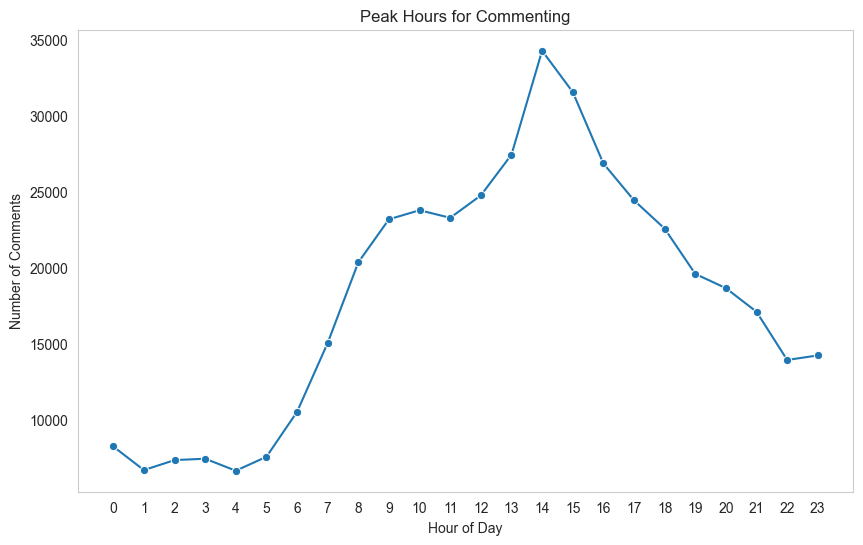

In [29]:
# 15 Peak Hours for Commenting
t_history['hour'] = t_history['hist_createdTime'].dt.hour
peak_hours = t_history['hour'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x=peak_hours.index, y=peak_hours.values, marker='o')
plt.title("Peak Hours for Commenting")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Comments")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

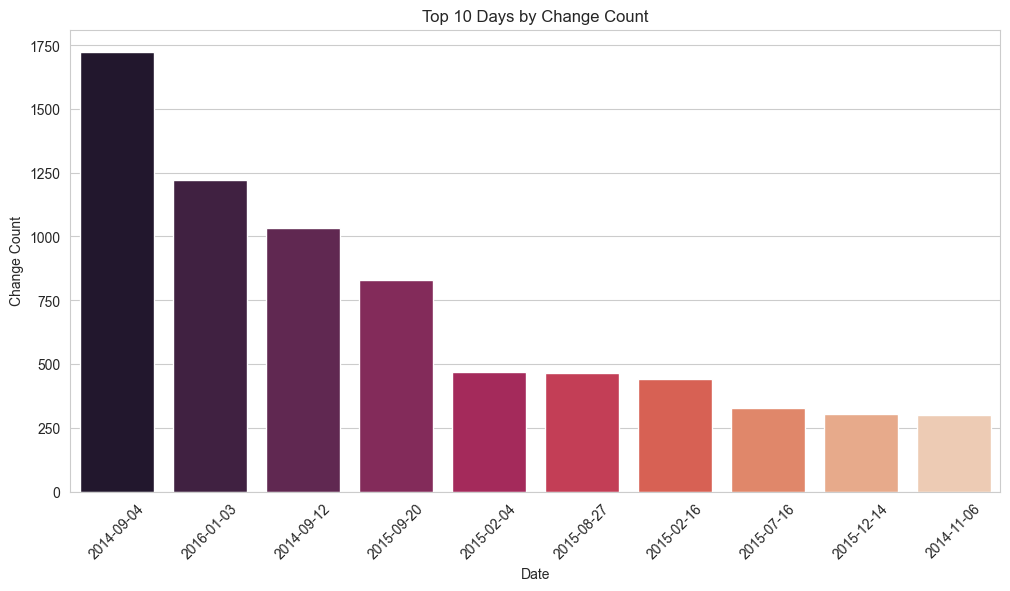

In [30]:
# 16 Days with Highest Change Activity
t_change['change_day'] = t_change['ch_createdTime'].dt.date
changes_per_day = t_change['change_day'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=changes_per_day.index.astype(str), y=changes_per_day.values, palette='rocket')
plt.title("Top 10 Days by Change Count")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Change Count")
plt.show()

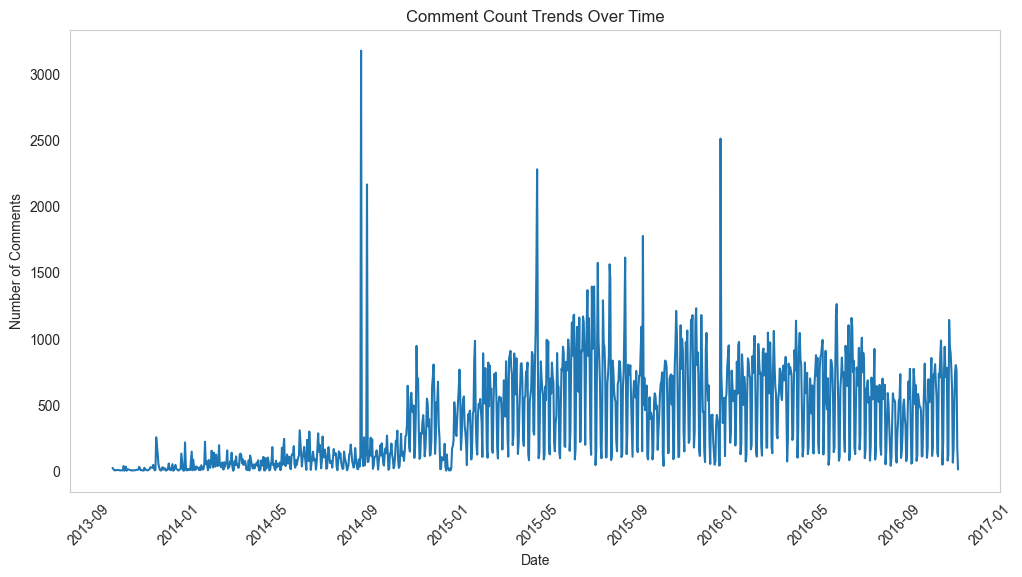

In [31]:
# 17 Comment Count Trends over Time
comment_trends = t_history.groupby(t_history['hist_createdTime'].dt.date).size()
plt.figure(figsize=(12, 6))
comment_trends.plot(kind='line')
plt.title("Comment Count Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [32]:
#18 Average Files Changed per Revision
files_per_revision = t_file.groupby('f_revisionId').size()
average_files_changed = files_per_revision.mean()
logger.info(f"Average files changed per revision: {round(average_files_changed)}")
print((f"Average files changed per revision: {round(average_files_changed)}"))


Average files changed per revision: 14


In [33]:
# 19. Projects with Highest Code Churn (lines inserted + lines deleted)
t_file['lines_changed'] = t_file['f_linesInserted'] + t_file['f_linesDeleted']
project_churn = t_file.merge(t_revision[['rev_changeId', 'id']], left_on='f_revisionId', right_on='id')
project_churn = project_churn.merge(t_change[['id', 'ch_project']], left_on='rev_changeId', right_on='id')
project_churn_summary = project_churn.groupby('ch_project')['lines_changed'].sum().nlargest(10)
print("Projects with Highest Code Churn:\n", project_churn_summary)
logger.info(f"Projects with Highest Code Churn:\n, {project_churn_summary}")

Projects with Highest Code Churn:
 ch_project
KutkoSergey/The_Third_Lab        43006614
yudatun/kernel                   37981560
midonet/midonet-docs             27156923
oceanobservatories/mi-dataset    19165636
daemyung/VulkanTutorials         16606297
irinelbogdan92/test-irinel        8043622
midonet/midonet                   7296638
getlantern/flashlight-build       6938880
Distrotech/coreutils              5139160
kenya888/my-jolla-rpms            4140981
Name: lines_changed, dtype: int64


In [34]:
# 20. Revisions with Most Comments (feedback-heavy revisions)
revision_comments = t_history.groupby(['hist_changeId', 'hist_patchSetNum']).size().nlargest(5).reset_index(name='comment_count')
print("Top 5 Feedback-Heavy Revisions:\n", revision_comments)
logger.info(f"Top 5 Feedback-Heavy Revisions:\n, {revision_comments}")

Top 5 Feedback-Heavy Revisions:
   hist_changeId hist_patchSetNum  comment_count
0         21203                6            661
1         21206                6            539
2         57182                4            174
3         36548               13            107
4         52838                1            105


### Recommendations and Optimizations

In [35]:
# Create alerts for prolonged reviews
prolonged_alert = t_change[t_change['change_duration'] > (Q3 + 1.5 * IQR)]
prolonged_alert['alert'] = 'Prolonged review, check blockers'
print("Prolonged Reviews with Alert:")
print(prolonged_alert[['id', 'alert']])

Prolonged Reviews with Alert:
          id                             alert
11        12  Prolonged review, check blockers
13        14  Prolonged review, check blockers
17        18  Prolonged review, check blockers
28        29  Prolonged review, check blockers
30        31  Prolonged review, check blockers
...      ...                               ...
57348  57349  Prolonged review, check blockers
57349  57350  Prolonged review, check blockers
57350  57351  Prolonged review, check blockers
57351  57352  Prolonged review, check blockers
57352  57353  Prolonged review, check blockers

[10865 rows x 2 columns]


In [36]:
# Setting up alerts for commit intervals exceeding thresholds
t_revision['commit_alert'] = np.where(t_revision['commit_interval'] > t_revision['commit_interval'].mean() + t_revision['commit_interval'].std(),
                                       'High commit interval - review process delay',
                                       'Normal')
print("Commit Interval Alerts:")
print(t_revision[['rev_changeId', 'commit_alert']])

Commit Interval Alerts:
      rev_changeId                                 commit_alert
0                1                                       Normal
12              10                                       Normal
304            100                                       Normal
305            100                                       Normal
1697          1000                                       Normal
...            ...                                          ...
14760         9995  High commit interval - review process delay
14761         9996                                       Normal
14762         9997                                       Normal
14763         9998                                       Normal
14764         9999                                       Normal

[106957 rows x 2 columns]


In [37]:
# Calculate revisions per change
revisions_per_change = t_revision.groupby('rev_changeId').size().reset_index(name='num_revisions')
high_revision_changes = revisions_per_change[revisions_per_change['num_revisions'] > revisions_per_change['num_revisions'].mean()]
print("High Revisions per Change (indicates complexity):")
print(high_revision_changes)

High Revisions per Change (indicates complexity):
      rev_changeId  num_revisions
2              100              2
18           10013              4
20           10015              3
22           10017              2
23           10018              2
...            ...            ...
57361         9989              3
57365         9992              5
57366         9993              5
57367         9994              3
57368         9995              8

[15542 rows x 2 columns]


In [38]:
## Revisions per Change: Projects with frequent revisions often correlate with high code complexity or evolving requirements, suggesting an area for potential optimization.
# Flagging high complexity projects
high_complexity_projects = revisions_per_change[revisions_per_change['num_revisions'] > revisions_per_change['num_revisions'].mean() + revisions_per_change['num_revisions'].std()]
print("Projects with High Complexity (consider pre-review):")
print(high_complexity_projects[['rev_changeId', 'num_revisions']])

Projects with High Complexity (consider pre-review):
      rev_changeId  num_revisions
79           10069             15
89           10078              9
100          10088             14
106          10093              7
126          10110              6
...            ...            ...
57332         9962              9
57346         9975              9
57365         9992              5
57366         9993              5
57368         9995              8

[3899 rows x 2 columns]


In [39]:
summary = {
    "Prolonged Reviews": prolonged_alert['id'].tolist(),
    "High Commit Interval Reviews": high_interval['id'].tolist(),
    "High Complexity Projects": high_complexity_projects['rev_changeId'].tolist()
}

In [ ]:
print("\nSummary of Insights and Recommendations:")
logger.info("\nSummary of Insights and Recommendations:")
for key, value in summary.items():
    print(f"{key}: {value}")
    logger.info(f"{key}: {value}")


Summary of Insights and Recommendations:
Prolonged Reviews: ['12', '14', '18', '29', '31', '32', '34', '36', '37', '40', '42', '43', '45', '46', '48', '59', '61', '64', '68', '77', '78', '80', '83', '85', '86', '87', '88', '89', '90', '91', '94', '95', '98', '99', '101', '105', '107', '109', '110', '144', '146', '149', '152', '155', '164', '165', '166', '167', '169', '170', '171', '173', '174', '175', '178', '180', '181', '183', '185', '186', '191', '194', '204', '266', '267', '270', '274', '275', '276', '277', '279', '284', '287', '289', '290', '291', '292', '293', '294', '297', '298', '299', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '378', '381', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '411', '551', '557', '563', '566', '569', '571', '575', '577', '578', '580', '581', '583', '586', '587', '588', '590', '591', '598', '607', '610', '613', '615', '627', '634', '635', '645', '666', '686', '688', '691', '749', '751', '753',

#### Summary of Insights

* Change Statistics:
A total of 55,560 unique changes were recorded.
   * The top three projects by change count are:
       1. midonet/midonet: 4,340 changes
       2. redhat-openstack/khaleesi: 2,915 changes
       3. Distrotech/linux: 1,758 changes

* Change Status:
Changes are predominantly in the MERGED state (38,595), followed by ABANDONED (10,592) and NEW (8,189).

* Branch Distribution:
The master branch leads with 36,270 changes, followed by distrotech-linux-3.14 (1,740) and next (1,421).

* Revision Insights:
   * The average revisions per change is 2.
   * The top five most revised changes had up to 125 revisions.

* Comment Statistics:
The average number of comments per change is 8.
The average comments per revision and feedback-heavy revisions indicate high engagement.

* Contributors:
    * The top contributor by change count is Account ID 1001050 with 3,346 changes.
    * The top contributor by revision count is Alex Bikfalvi with 2,760 revisions.

* Code Changes:
   * Projects with the highest code churn indicate substantial activity, with the top project, KutkoSergey/The_Third_Lab, having 43,006,614 lines changed.

In summary, this analysis not only underscores the strengths of the current development processes but also identifies areas for improvement, setting the stage for ongoing enhancements that will drive greater efficiency, collaboration, and success in future projects.